In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors  
from rdkit.Chem import Lipinski
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

#import pubchempy as pcp
#from IPython.display import Imag

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns 

In [2]:
def clean_CF(smi):
    mol = Chem.ReplaceSubstructs(Chem.MolFromSmiles(smi), 
                                 Chem.MolFromSmiles('CF'), 
                                 Chem.MolFromSmiles('C'),
                                 replaceAll=True)
    smi = Chem.MolToSmiles(mol[0], canonical=True, isomericSmiles=True) 
    return smi

def remove_F(smi):
    #smi = smi.replace("[F]","")
    smi = smi.replace("(F)","")
    smi = smi.replace("F","")
    mol = Chem.MolFromSmiles(smi)
    smi = Chem.MolToSmiles(mol, canonical=True, isomericSmiles=True)
    return smi

def replace_CF(base_smi, add_smi):
    mol = Chem.ReplaceSubstructs(Chem.MolFromSmiles(base_smi), 
                                 Chem.MolFromSmiles('CF'), 
                                 Chem.MolFromSmiles(add_smi),
                                 replaceAll=False)
    smi = [ Chem.MolToSmiles(m, canonical=True, isomericSmiles=True) for m in mol ]
    smi = list(set(smi))
    if base_smi in smi:
        smi.remove(base_smi)
    return smi

def add_CF(base_smi, add_smi='C', if_replace_all=True):
    mol = Chem.ReplaceSubstructs(Chem.MolFromSmiles(base_smi), 
                                 Chem.MolFromSmiles(add_smi), 
                                 Chem.MolFromSmiles('CF'),
                                 replaceAll=if_replace_all)
    smi = [ Chem.MolToSmiles(m, canonical=True, isomericSmiles=True) for m in mol ]
    smi = list(set(smi))
    return smi

def add_F(smi):
    smi = Chem.MolToSmiles(Chem.AddHs( Chem.MolFromSmiles(smi) ), canonical=True, isomericSmiles=True)
    smi = smi.replace('[H]','F')
    return smi

In [23]:
# Replace the F site
from tqdm import tqdm
from time import sleep

def add_functionality(base_molecules, func_molecules):  ## two lists of SMILES
    new_molecules = []  ## The new templates
    ## Pick the base template
    if len(base_molecules)>0:
        for i,b in zip(tqdm(range(len(base_molecules))), base_molecules):
            #sleep(0.000000001)
            for f in func_molecules:
                new = list(replace_CF(b, f) )
                if len(new)>0:
                    new_molecules += new
    new_molecules = pd.DataFrame(new_molecules, columns=['SMILES'])
    new_molecules['INCHI'] = [ Chem.MolToInchi( Chem.MolFromSmiles(s)) for s in new_molecules['SMILES'] ]
    #display( 'Old template length: ', len(new_molecules) )
    new_molecules = new_molecules.drop_duplicates(subset=['INCHI'])
    #display( 'New template length: ', len(new_molecules) )
    new_molecules = list( new_molecules['SMILES'] )
    
    df_molecules = pd.DataFrame( [remove_F(s) for s in new_molecules], columns=['SMILES'])
    df_molecules['INCHI'] = [ Chem.MolToInchi( Chem.MolFromSmiles(m) ) for m in df_molecules['SMILES'] ]
    #display( 'Old dienes length: ', len(df_molecules) )
    df_molecules = df_molecules.drop_duplicates(subset=['INCHI'])
    display( 'New dienes length: ', len(df_molecules) )

    return new_molecules, df_molecules

# Functional groups and base considered in the short list

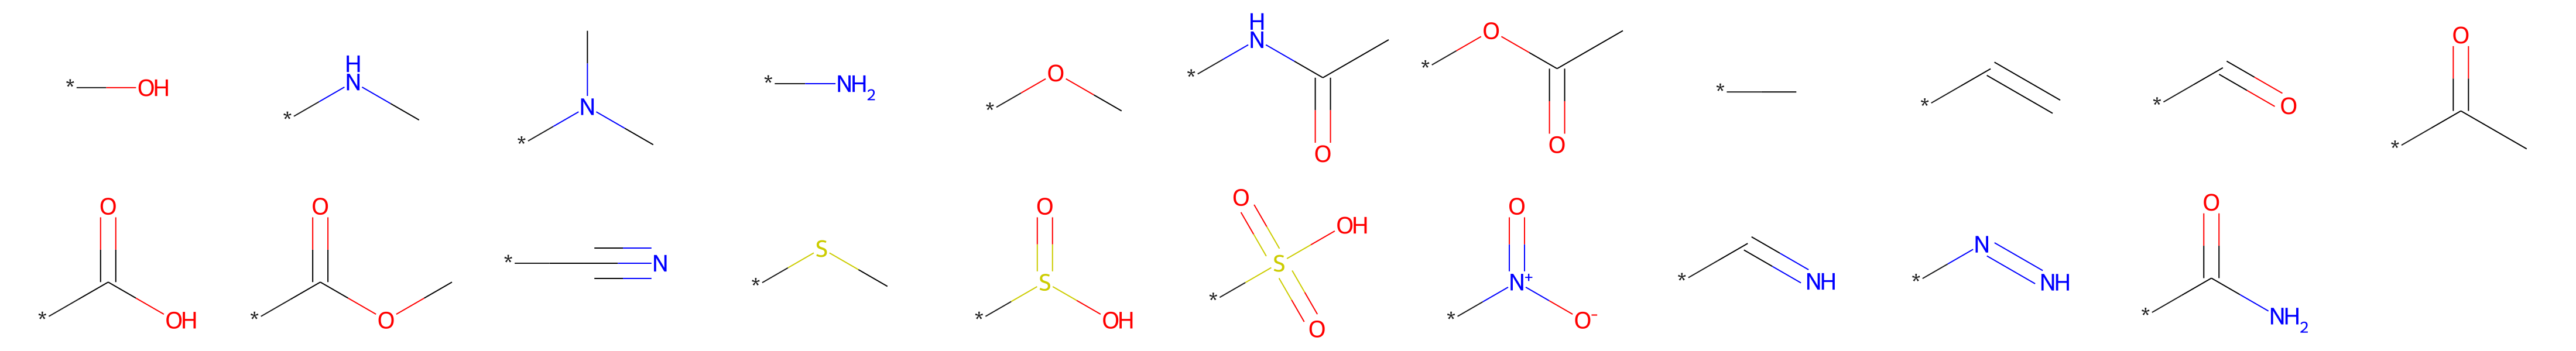

In [15]:
func = [
    'CO', 'CNC', 'CN(C)C', 'CN', 'COC', #'COCC',   ## EDG strong
    'CNC(=O)C', 'COC(=O)C',  ## EDG moderate
    'CC', 'CC=C', #'CC=CC',  ## EDG weak
    ##'C',
    'CC=O', 'CC(=O)C', 'CC(=O)O', 'CC(=O)OC',   # EWG moderate
    'CC#N', 'CSC', 'CS(=O)O', 'CS(=O)(=O)O','C[N+](=O)[O-]',  ## EWG Strong
    
    'CC=N', 'CN=N', 'CC(=O)N', #'CON', 'CCO','CNO',  ## Should be EWG
]
img = Draw.MolsToGridImage( [Chem.MolFromSmiles('*'+p[1:]) for p in func], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
img.save('Functional_groups_in_ShortList.png')
display(img)

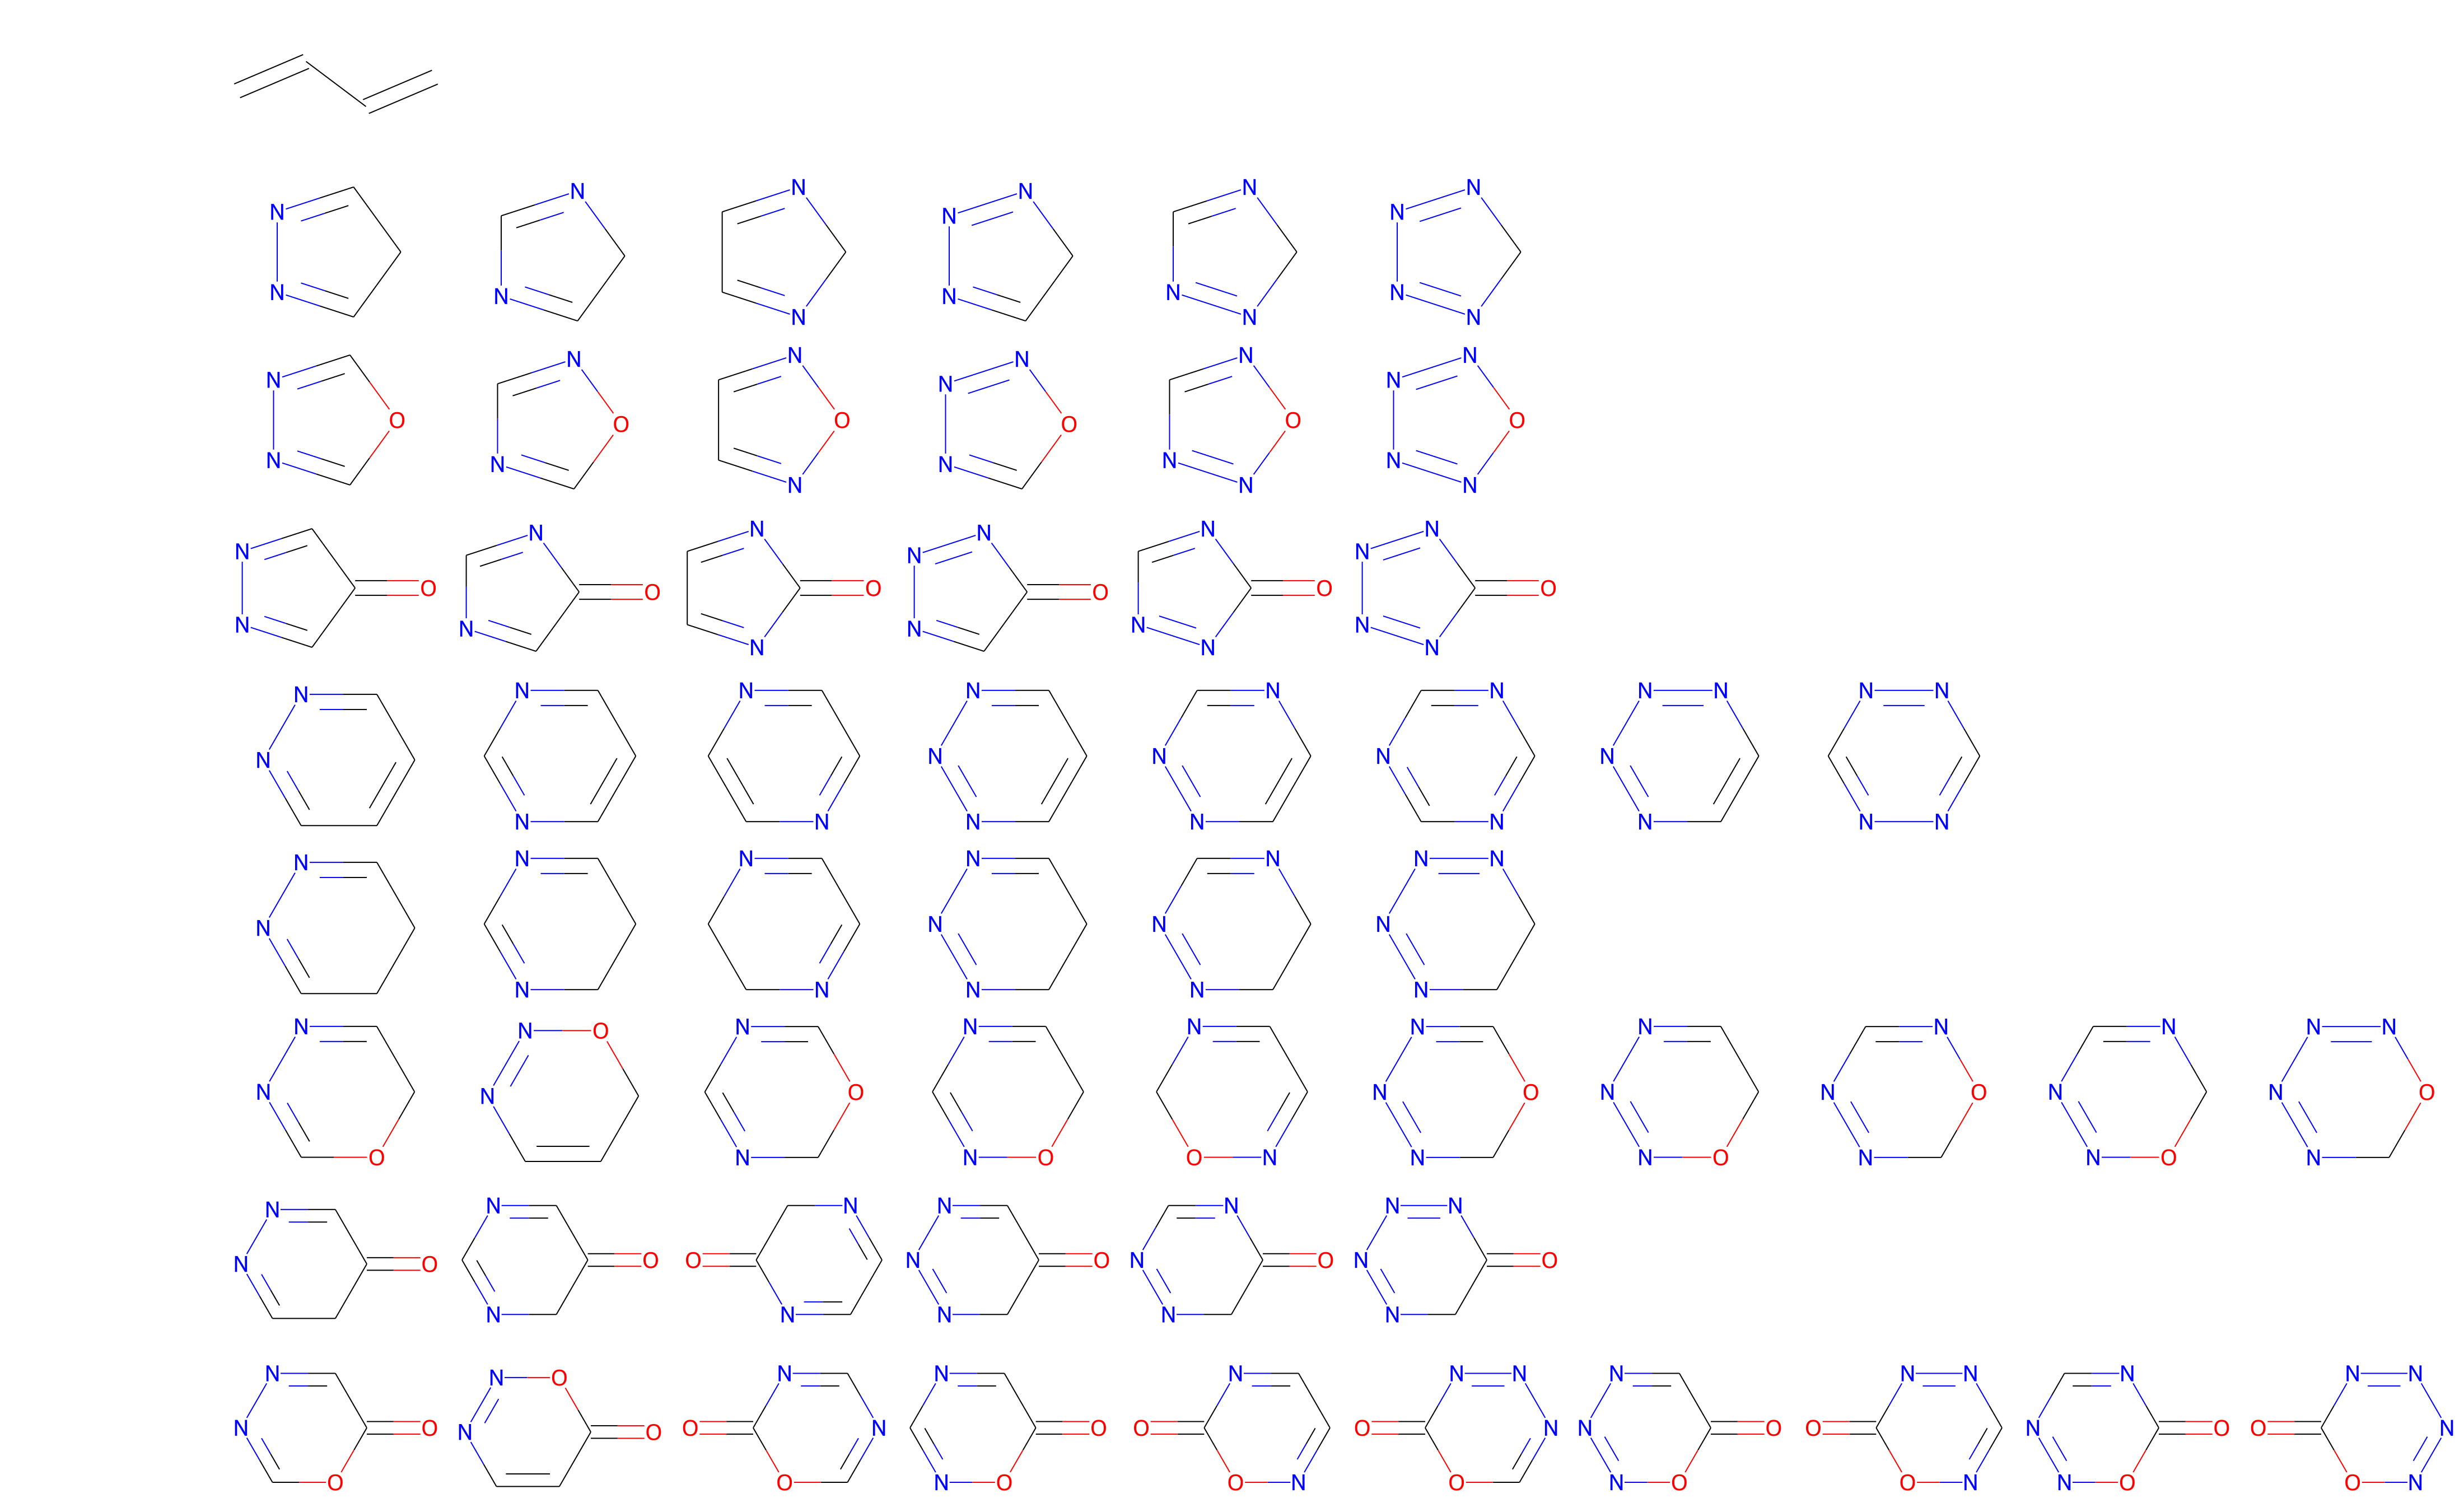

In [16]:
base_13diene = ['C=CC=C']

# 5-membered ring
diazine = ['C1-C=NN=C1', 'C1-N=CN=C1', 'C1-N=CC=N1',]
triazine = ['C1-N=NN=C1', 'C1-N=CN=N1',]
tetrazine = ['C1-N=NN=N1', ]
smiles5 = diazine+triazine+tetrazine
# ADD O
diazine2 = ['O1-C=NN=C1','O1-N=CN=C1','O1-N=CC=N1',]
triazine2 = ['O1-N=NN=C1', 'O1-N=CN=N1', ]
tetrazine2 = [ 'O1-N=NN=N1', ]
smiles5o = diazine2+triazine2+tetrazine2
# Add =O
diazine3 = ['C1(=O)-C=NN=C1', 'C1(=O)-N=CN=C1', 'C1(=O)-N=CC=N1',]
triazine3 = ['C1(=O)-N=NN=C1', 'C1(=O)-N=CN=N1',]
tetrazine3 = ['C1(=O)-N=NN=N1', ]
smiles5o2 = diazine3+triazine3+tetrazine3

# 6-membered ring
diazine = ['C1=CC=NN=C1', 'C1=CN=CN=C1', 'C1=NC=CN=C1', ] # 1,2-diazine # 1,3-diazine # 1,4-diazine
triazine = ['C1=CN=NN=C1', 'C1=CN=NC=N1', 'C1=NC=NC=N1', ] # 1,2,3-triazine # 1,2,4-Triazine # 1,3,5-Triazine
tetrazine = ['C1=CN=NN=N1', 'C1=NN=CN=N1', ]#1,2,3,4-Tetrazine #1,2,4,5-Tetrazine
smiles6 = diazine+triazine+tetrazine
## Add O
diazine2 = ['C1OC=NN=C1', 'C1C=CN=NO1', 'O1CN=CN=C1', 'C1ON=CN=C1', 'C1=NOCN=C1', ]
triazine2 = ['O1CN=NN=C1', 'C1ON=NN=C1', 'O1CN=NC=N1', 'C1ON=NC=N1', ]   
tetrazine2 = [ 'O1CN=NN=N1', ]
smiles6o = diazine2+triazine2+tetrazine2
# Add CH
diazine3 = ['C1CC=NN=C1', 'C1CN=CN=C1', 'C1=NCCN=C1',]
triazine3 = ['C1CN=NN=C1', 'C1CN=NC=N1', ]   
tetrazine3 = [ 'C1CN=NN=N1']
smiles6c = diazine3+triazine3+tetrazine3
# Add =O
diazine4 = ['C1(=O)CC=NN=C1', 'C1(=O)CN=CN=C1', 'C1=NC(=O)CN=C1',]
triazine4 = ['C1(=O)CN=NN=C1', 'C1(=O)CN=NC=N1', ]   
tetrazine4 = [ 'C1(=O)CN=NN=N1']
smiles6o2 = diazine4+triazine4+tetrazine4
# Add =O,O
diazine5 = ['C1(=O)OC=NN=C1', 'C1(=O)C=CN=NO1', 'O1C(=O)N=CN=C1', 'C1(=O)ON=CN=C1', 'C1=NOC(=O)N=C1',]
triazine5 = ['O1C(=O)N=NN=C1', 'C1(=O)ON=NN=C1', 'O1C(=O)N=NC=N1', 'C1(=O)ON=NC=N1',]   
tetrazine5 = [ 'O1C(=O)N=NN=N1' ]
smiles6oo = diazine5+triazine5+tetrazine5

smiles_all = [base_13diene, smiles5, smiles5o, smiles5o2,   smiles6, smiles6c, smiles6o, smiles6o2,smiles6oo]

imgs = []
for n,smi in enumerate(smiles_all):
    img = Draw.MolsToGridImage( [None]+[Chem.MolFromSmiles(s) for s in smi], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] ) 
    imgs.append(img)
    #display(img)
    
from PIL import Image
def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

combined_img = get_concat_v(imgs[0], imgs[1])
for img in imgs[2:]:
    combined_img = get_concat_v(combined_img, img)    

combined_img.save(f'Templates_all.png')
combined_img

In [6]:
for n,smi in enumerate(smiles_all):
    smi = Chem.AddHs(Chem.MolFromSmiles(smi[0]))
    smi = Chem.MolToSmiles(smi, canonical=True, isomericSmiles=True)
    smi = smi.replace( "H","*")
    img = Draw.MolsToGridImage( [Chem.MolFromSmiles(smi)], molsPerRow=1, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] ) 
    img.save(f'Templates_{n}.png')
    #display(img)

# For 1,3-butadiene

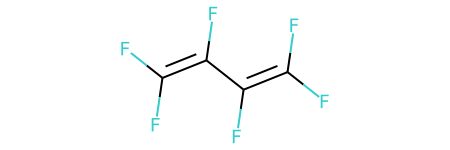

In [33]:
## 1,3-butadiene
base_diene = 'C(F)(F)=C(F)C(F)=C(F)(F)'
display(Chem.MolFromSmiles( base_diene ))
## Functional group list  ------->>> This is too many. So we narrow down in the next box.
#func = pd.read_csv( 'list_of_func_ready_to_pair.csv', index_col=0) 
#func = [ 'C'+d[1:] for d in func['SMILES'] ]
#print( func )

In [34]:
%%capture --no-display
# Replace one site
new_molecules_1 = []  ## The template. did NOT remove F in this one
for f in func:
    new = list(replace_CF(base_diene, f) )  # Add the functional group 
    new_molecules_1 += new
new_molecules_1 = pd.DataFrame(new_molecules_1, columns=['SMILES'])
new_molecules_1['INCHI'] = [ Chem.MolToInchi( Chem.MolFromSmiles(s)) for s in new_molecules_1['SMILES'] ]
display( 'Old length: ', len(new_molecules_1) )
new_molecules_1 = new_molecules_1.drop_duplicates(subset=['INCHI'])
display( 'New length: ', len(new_molecules_1) )
new_molecules_1 = list( new_molecules_1['SMILES'] )
#new_molecules_1

'Old length: '

42

'New length: '

42

In [35]:
%%capture --no-display

#df1 = pd.DataFrame([clean_CF(s) for s in new_molecules_1], columns=['SMILES'])
df1 = pd.DataFrame( [remove_F(s) for s in new_molecules_1], columns=['SMILES'])
df1['INCHI'] = [ Chem.MolToInchi( Chem.MolFromSmiles(m) ) for m in df1['SMILES'] ]
display( 'Old length: ', len(df1) )
df1 = df1.drop_duplicates(subset=['INCHI'])
display( df1.shape, df1.head() )

'Old length: '

42

(42, 2)

,SMILES,INCHI
0,C=CC=CO,"InChI=1S/C4H6O/c1-2-3-4-5/h2-5H,1H2"
1,C=CC(=C)O,"InChI=1S/C4H6O/c1-3-4(2)5/h3,5H,1-2H2"
2,C=CC(=C)NC,"InChI=1S/C5H9N/c1-4-5(2)6-3/h4,6H,1-2H2,3H3"
3,C=CC=CNC,"InChI=1S/C5H9N/c1-3-4-5-6-2/h3-6H,1H2,2H3"
4,C=CC(=C)N(C)C,"InChI=1S/C6H11N/c1-5-6(2)7(3)4/h5H,1-2H2,3-4H3"


In [36]:
df1.to_csv('ShortList_One_functionalized_13butadiene.csv')

In [37]:
%%capture --no-display
# Replace the second site
new_molecules_2, df2 = add_functionality(new_molecules_1, func)
df2.to_csv('ShortList_Two_functionalized_13butadiene.csv')

'Old template length: '

3087

'New template length: '

1575

'Old dienes length: '

1575

'New dienes length: '

1554

In [38]:
%%capture --no-display
# Replace the Three site
new_molecules_3, df3 = add_functionality(new_molecules_2, func)
df3.to_csv('ShortList_Three_functionalized_13butadiene.csv')

'Old template length: '

97902

'New template length: '

33075

'Old dienes length: '

33075

'New dienes length: '

32865

In [39]:
%%capture --no-display
# Replace the Three site
new_molecules_4, df4 = add_functionality(new_molecules_3, func)
df4.to_csv('ShortList_Four_functionalized_13butadiene.csv')

'Old template length: '

1685502

'New template length: '

429870

'Old dienes length: '

429870

'New dienes length: '

429870

# Ring N-diene

## See these dienes

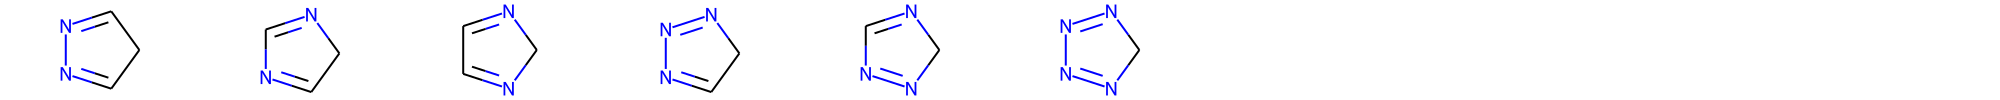

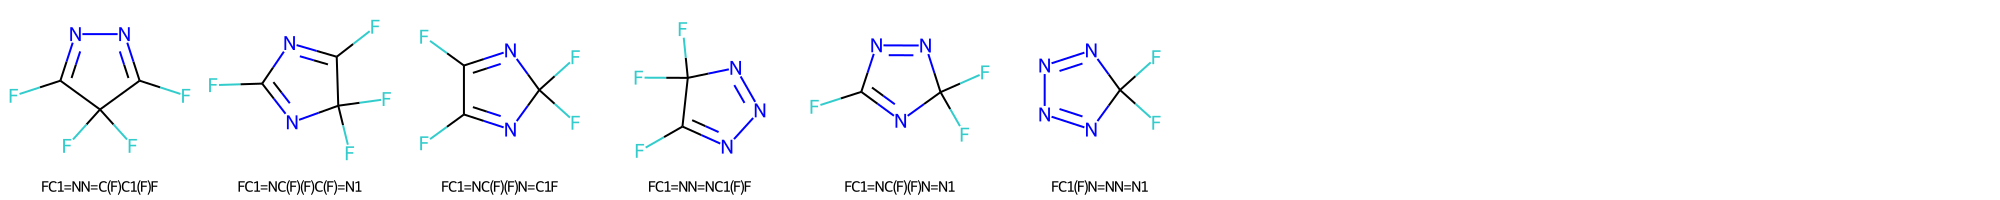

' '

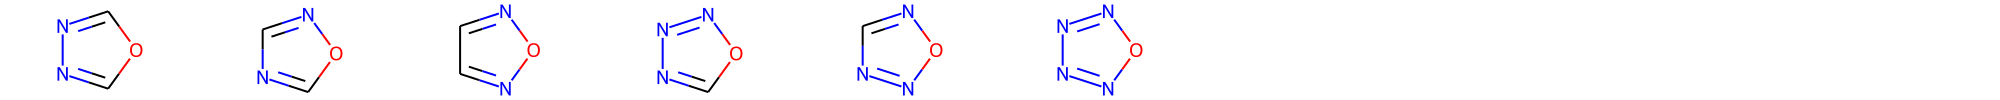

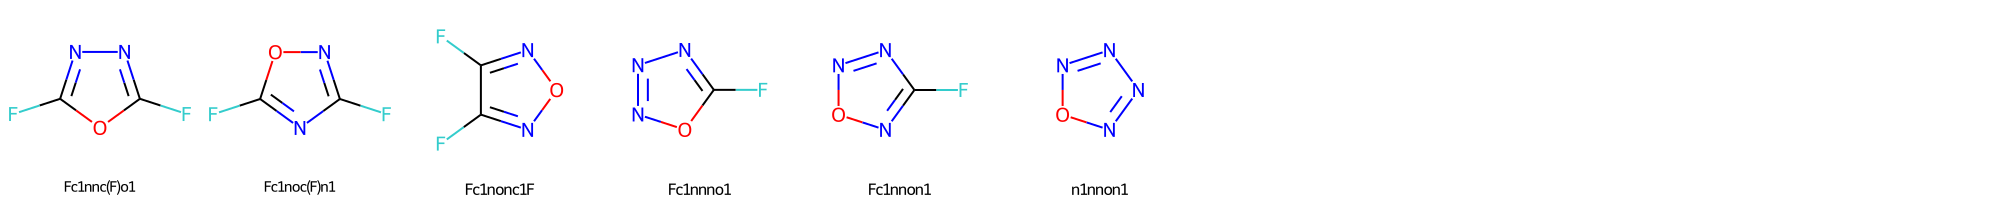

' '

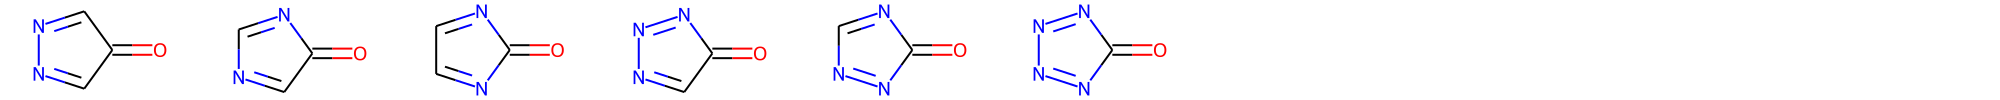

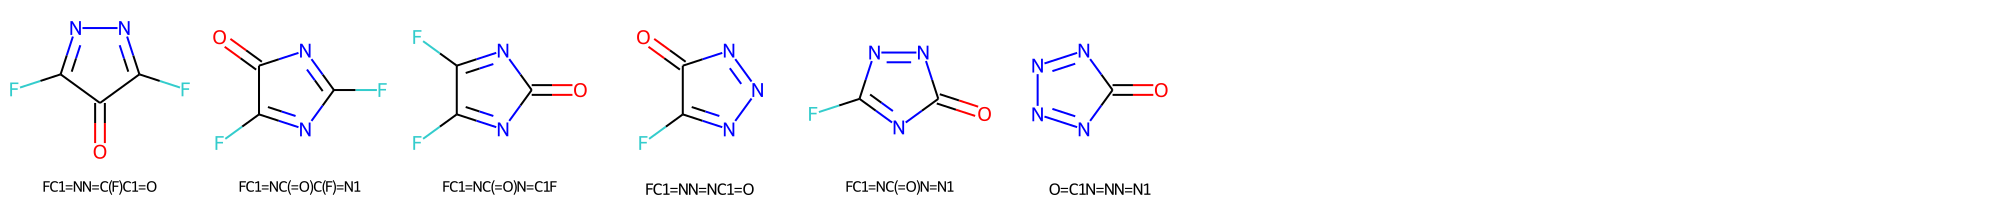

' '

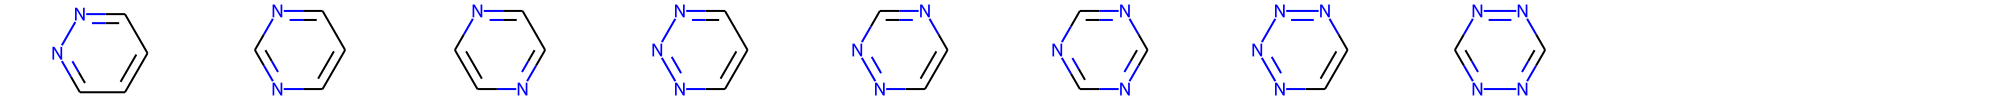

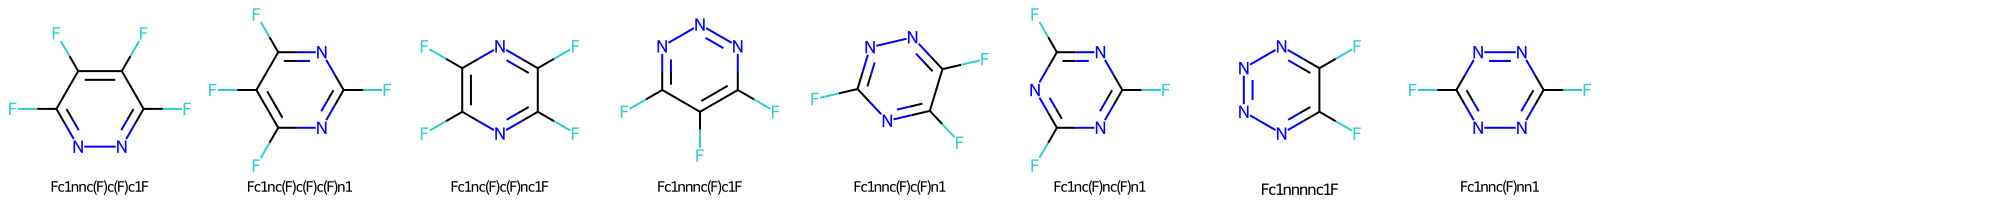

' '

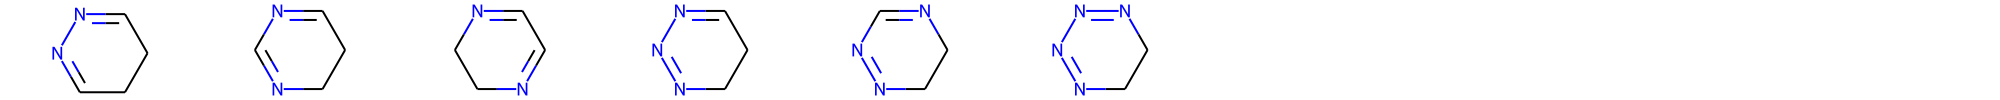

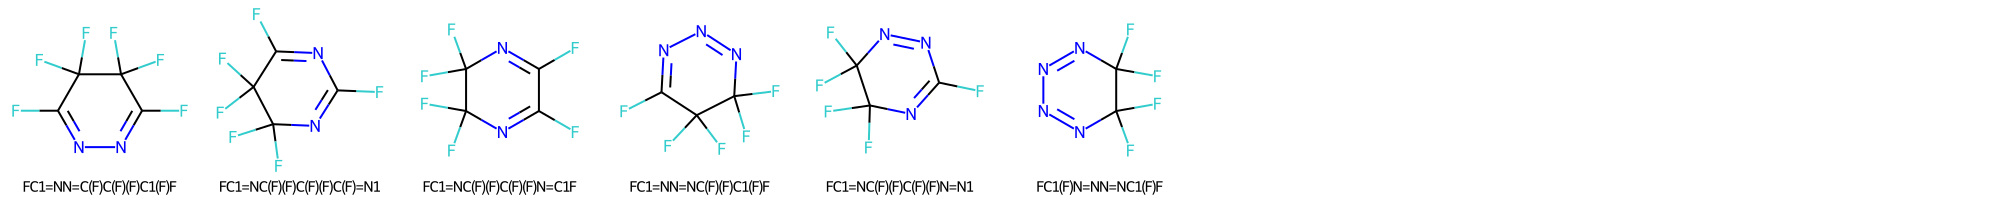

' '

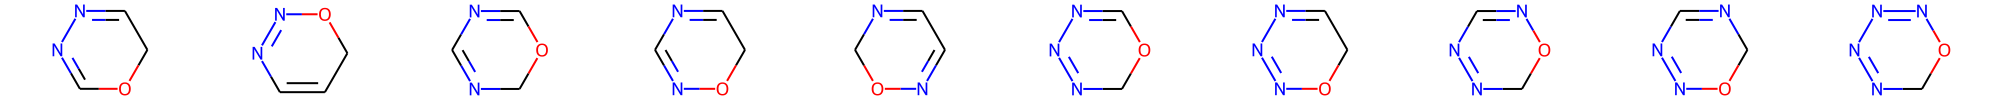

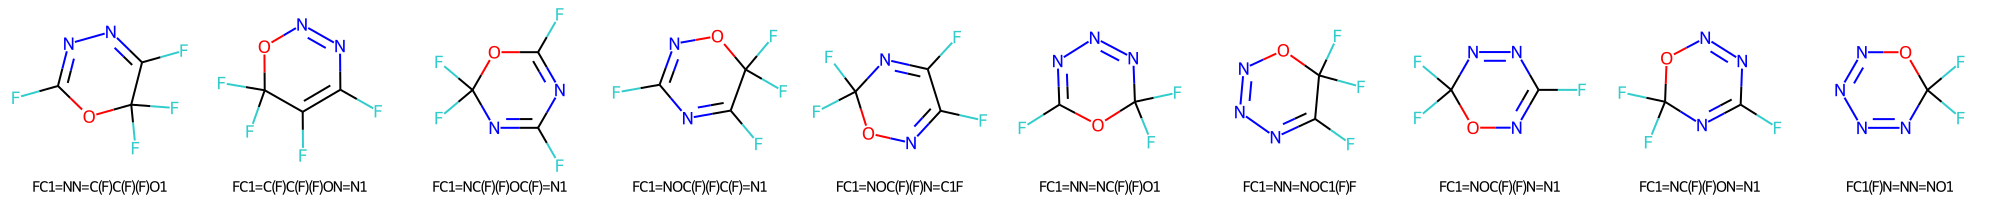

' '

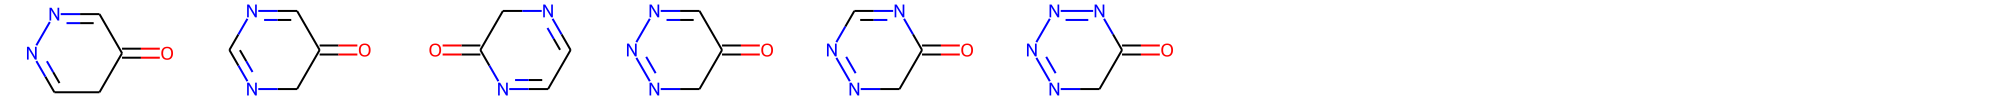

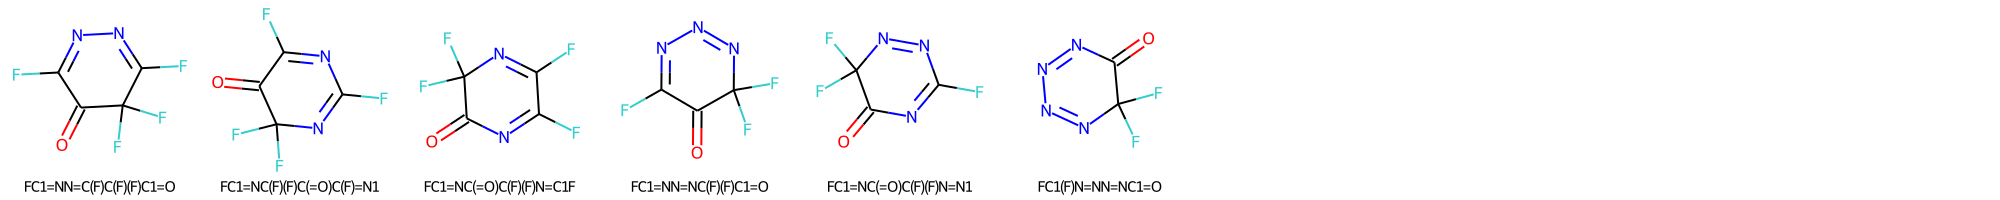

' '

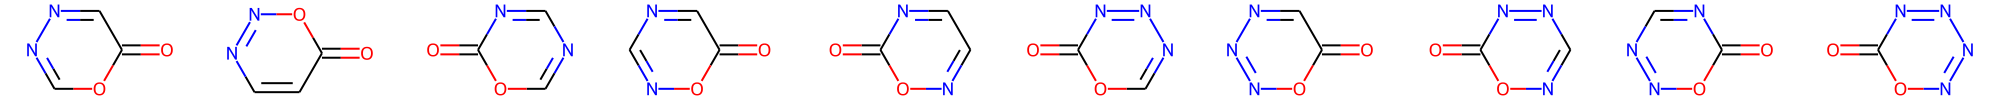

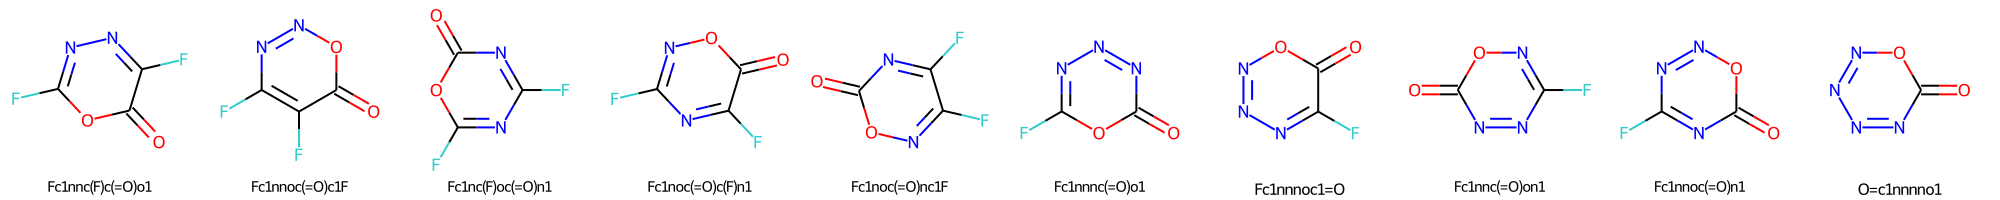

' '

In [17]:
smiles_ring = smiles_all[1:]

smiles_template = []
for n,smi in enumerate(smiles_ring):
    each_temp = [ add_F(s) for s in smi ]
    img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in smi], molsPerRow=10, subImgSize=(200, 100), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] ) 
    display(img)    
    img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in each_temp], molsPerRow=10, subImgSize=(200, 200), returnPNG=False ,legends=[s for s in each_temp] ) 
    display(img)
    display(' ')
    smiles_template.append(each_temp)

## Now make new molecules 

In [18]:
## No functionalization
new_molecules_0 = []
for ii, t in enumerate(smiles_template):
    new = [remove_F(smi) for smi in t]
    print( len(new) )
    new = pd.DataFrame(new, columns=['SMILES'])
    new['type'] = ii
    new_molecules_0.append( new )
df0 = pd.concat( new_molecules_0, axis=0 )
df0['INCHI'] = [ Chem.MolToInchi( Chem.MolFromSmiles(m) ) for m in df0['SMILES'] ]
df0 = df0.drop_duplicates(subset=['INCHI'])

df0.to_csv('ShortList_None_functionalized_Nring.csv')

df0.shape

6
6
6
8
6
10
6
10


(58, 3)

In [19]:
%%capture --no-display
# Replace one site: 
new_molecules_1 = []  ## The template. did NOT remove F in this one. A list of lists
for temp in smiles_template:
    each_template = []
    for t in temp:
        for f in func:
            new = list(replace_CF(t, f) )  # Add the functional group 
            each_template += new
    new_molecules_1.append( each_template )
    print( len(each_template) )
    
df1_all = []
for ii, mol in enumerate(new_molecules_1):
    mol = pd.DataFrame(mol, columns=['SMILES'])
    mol['INCHI'] = [ Chem.MolToInchi( Chem.MolFromSmiles(s)) for s in mol['SMILES'] ]
    #display( 'Old length: ', len(mol) )
    mol = mol.drop_duplicates(subset=['INCHI'])
    #display( 'New length: ', len(mol) )

    df1 = pd.DataFrame( [remove_F(s) for s in mol['SMILES']], columns=['SMILES'])
    df1['INCHI'] = [ Chem.MolToInchi( Chem.MolFromSmiles(m) ) for m in df1['SMILES'] ]
    #display( 'Old length: ', len(df1) )
    df1 = df1.drop_duplicates(subset=['INCHI'])
    display( 'Final df: ', df1.shape)
    
    df1['type'] = ii
    df1_all.append( df1 )
    
df1_all = pd.concat( df1_all, axis=0 )
display(df1_all)
df1_all.to_csv('ShortList_One_functionalized_Nring.csv')

'Final df: '

(252, 2)

'Final df: '

(126, 2)

'Final df: '

(125, 2)

'Final df: '

(294, 2)

'Final df: '

(315, 2)

'Final df: '

(504, 2)

'Final df: '

(294, 2)

'Final df: '

(294, 2)

,SMILES,INCHI,type
0,OC1=NN=CC1,"InChI=1S/C3H4N2O/c6-3-1-2-4-5-3/h2H,1H2,(H,5,6)",0
1,OC1C=NN=C1,"InChI=1S/C3H4N2O/c6-3-1-4-5-2-3/h1-3,6H",0
2,CNC1=NN=CC1,"InChI=1S/C4H7N3/c1-5-4-2-3-6-7-4/h3H,2H2,1H3,(...",0
3,CNC1C=NN=C1,"InChI=1S/C4H7N3/c1-5-4-2-6-7-3-4/h2-5H,1H3",0
4,CN(C)C1C=NN=C1,"InChI=1S/C5H9N3/c1-8(2)5-3-6-7-4-5/h3-5H,1-2H3",0
...,...,...,...
289,O=c1nc(S(=O)(=O)O)nno1,"InChI=1S/C2HN3O5S/c6-2-3-1(4-5-10-2)11(7,8)9/h...",7
290,O=c1nc([N+](=O)[O-])nno1,InChI=1S/C2N4O4/c7-2-3-1(6(8)9)4-5-10-2,7
291,N=Cc1nnoc(=O)n1,"InChI=1S/C3H2N4O2/c4-1-2-5-3(8)9-7-6-2/h1,4H",7
292,N=Nc1nnoc(=O)n1,InChI=1S/C2HN5O2/c3-5-1-4-2(8)9-7-6-1/h3H,7


In [20]:
%%capture --no-display
# Replace the second site
new_molecules_2, df2_all = [],[]  ## the templates and new molecules
for ii, each_template in enumerate(new_molecules_1):
    new, df = add_functionality(each_template, func)
    new_molecules_2.append(new)
    df['type'] = ii
    df2_all.append( df )
df2_all = pd.concat( df2_all, axis=0 )
display(df2_all)

df2_all.to_csv('ShortList_Two_functionalized_Nring.csv')

'New dienes length: '

4935

'New dienes length: '

903

'New dienes length: '

882

'New dienes length: '

6279

'New dienes length: '

10290

'New dienes length: '

10689

'New dienes length: '

6237

'New dienes length: '

2205

,SMILES,INCHI,type
0,OC1=NN=CC1O,"InChI=1S/C3H4N2O2/c6-2-1-4-5-3(2)7/h1-2,6H,(H,...",0
1,OC1=NN=C(O)C1,"InChI=1S/C3H4N2O2/c6-2-1-3(7)5-4-2/h1H2,(H,4,6...",0
2,CNC1C=NN=C1O,"InChI=1S/C4H7N3O/c1-5-3-2-6-7-4(3)8/h2-3,5H,1H...",0
3,CNC1=NN=C(O)C1,"InChI=1S/C4H7N3O/c1-5-3-2-4(8)7-6-3/h2H2,1H3,(...",0
4,CN(C)C1=NN=C(O)C1,"InChI=1S/C5H9N3O/c1-8(2)4-3-5(9)7-6-4/h3H2,1-2...",0
...,...,...,...
2200,N=Cc1nc(=O)onc1C(N)=O,InChI=1S/C5H4N4O3/c6-1-2-3(4(7)10)9-12-5(11)8-...,7
2201,N=Nc1noc(=O)nc1N=N,InChI=1S/C3H2N6O2/c4-7-1-2(8-5)9-11-3(10)6-1/h...,7
2202,N=Nc1noc(=O)nc1C(N)=O,InChI=1S/C4H3N5O3/c5-2(10)1-3(8-6)9-12-4(11)7-...,7
2203,N=Nc1nc(=O)onc1C(N)=O,InChI=1S/C4H3N5O3/c5-2(10)1-3(8-6)7-4(11)12-9-...,7


In [21]:
for m in new_molecules_2:
    print( len(m))

4935
903
882
6279
10290
10689
6237
2205


In [22]:
%%capture --no-display
# Replace the Three site
new_molecules_3, df3_all = [],[]  ## the templates and new molecules
for ii, each_template in enumerate(new_molecules_2):
    new, df = add_functionality(each_template, func)
    new_molecules_3.append(new)
    df['type'] = ii
    df3_all.append( df )
df3_all = pd.concat( df3_all, axis=0 )
display(df3_all)

df3_all.to_csv('ShortList_Three_functionalized_Nring.csv')

'New dienes length: '

48069

'New dienes length: '

0

'New dienes length: '

0

'New dienes length: '

62629

'New dienes length: '

194481

'New dienes length: '

114219

'New dienes length: '

66591

'New dienes length: '

0

,SMILES,INCHI,type
0,OC1=NN=C(O)C1O,"InChI=1S/C3H4N2O3/c6-1-2(7)4-5-3(1)8/h1,6H,(H,...",0
1,OC1=NN=CC1(O)O,"InChI=1S/C3H4N2O3/c6-2-3(7,8)1-4-5-2/h1,7-8H,(...",0
2,CNC1(O)C=NN=C1O,"InChI=1S/C4H7N3O2/c1-5-4(9)2-6-7-3(4)8/h2,5,9H...",0
3,CNC1=NN=C(O)C1O,"InChI=1S/C4H7N3O2/c1-5-3-2(8)4(9)7-6-3/h2,8H,1...",0
4,CN(C)C1(O)C=NN=C1O,"InChI=1S/C5H9N3O2/c1-8(2)5(10)3-6-7-4(5)9/h3,1...",0
...,...,...,...
66586,N=NC1=NC(=O)C(N=N)(C(N)=O)N=N1,InChI=1S/C4H4N8O2/c5-1(13)4(11-7)2(14)8-3(9-6)...,6
66587,N=NC1=NC(=O)C(C(N)=O)(C(N)=O)N=N1,InChI=1S/C5H5N7O3/c6-1(13)5(2(7)14)3(15)9-4(10...,6
66588,N=NC1(N=N)N=NC(C(N)=O)=NC1=O,"InChI=1S/C4H4N8O2/c5-1(13)2-8-3(14)4(10-6,11-7...",6
66589,N=NC1(C(N)=O)N=NC(C(N)=O)=NC1=O,"InChI=1S/C5H5N7O3/c6-1(13)2-9-4(15)5(11-8,3(7)...",6


In [24]:
for m in new_molecules_3:
    print( len(m))

48069
0
0
62629
194481
114219
66591
0


In [25]:
%%capture --no-display
# Replace the Four site
new_molecules_4, df4_all = [],[]  ## the templates and new molecules
for ii, each_template in enumerate(new_molecules_3):
    new, df = add_functionality(each_template, func)
    new_molecules_4.append(new)
    df['type'] = ii
    df4_all.append( df )
df4_all = pd.concat( df4_all, axis=0 )
display(df4_all)

df4_all.to_csv('ShortList_Four_functionalized_Nring.csv')

'New dienes length: '

208593

'New dienes length: '

0

'New dienes length: '

0

'New dienes length: '

248283

'New dienes length: '

2259810

'New dienes length: '

509355

'New dienes length: '

305613

'New dienes length: '

0

,SMILES,INCHI,type
0,OC1=NN=C(O)C1(O)O,"InChI=1S/C3H4N2O4/c6-1-3(8,9)2(7)5-4-1/h8-9H,(...",0
1,CNC1(O)C(O)=NN=C1O,"InChI=1S/C4H7N3O3/c1-5-4(10)2(8)6-7-3(4)9/h5,1...",0
2,CN(C)C1(O)C(O)=NN=C1O,InChI=1S/C5H9N3O3/c1-8(2)5(11)3(9)6-7-4(5)10/h...,0
3,NC1(O)C(O)=NN=C1O,"InChI=1S/C3H5N3O3/c4-3(9)1(7)5-6-2(3)8/h9H,4H2...",0
4,COC1(O)C(O)=NN=C1O,"InChI=1S/C4H6N2O4/c1-10-4(9)2(7)5-6-3(4)8/h9H,...",0
...,...,...,...
305608,N=NC1(N=N)N=C(C(N)=O)C(C(N)=O)=NC1=O,InChI=1S/C6H6N8O3/c7-3(15)1-2(4(8)16)12-6(13-9...,6
305609,N=NC1=NC(N=N)(C(N)=O)C(=O)N=C1C(N)=O,"InChI=1S/C6H6N8O3/c7-2(15)1-3(13-9)12-6(14-10,...",6
305610,N=NC1(C(N)=O)N=C(C(N)=O)C(C(N)=O)=NC1=O,InChI=1S/C7H7N7O4/c8-3(15)1-2(4(9)16)13-7(14-1...,6
305611,N=NC1=NC(C(N)=O)(C(N)=O)C(=O)N=C1C(N)=O,InChI=1S/C7H7N7O4/c8-2(15)1-3(14-11)13-7(4(9)1...,6


3200


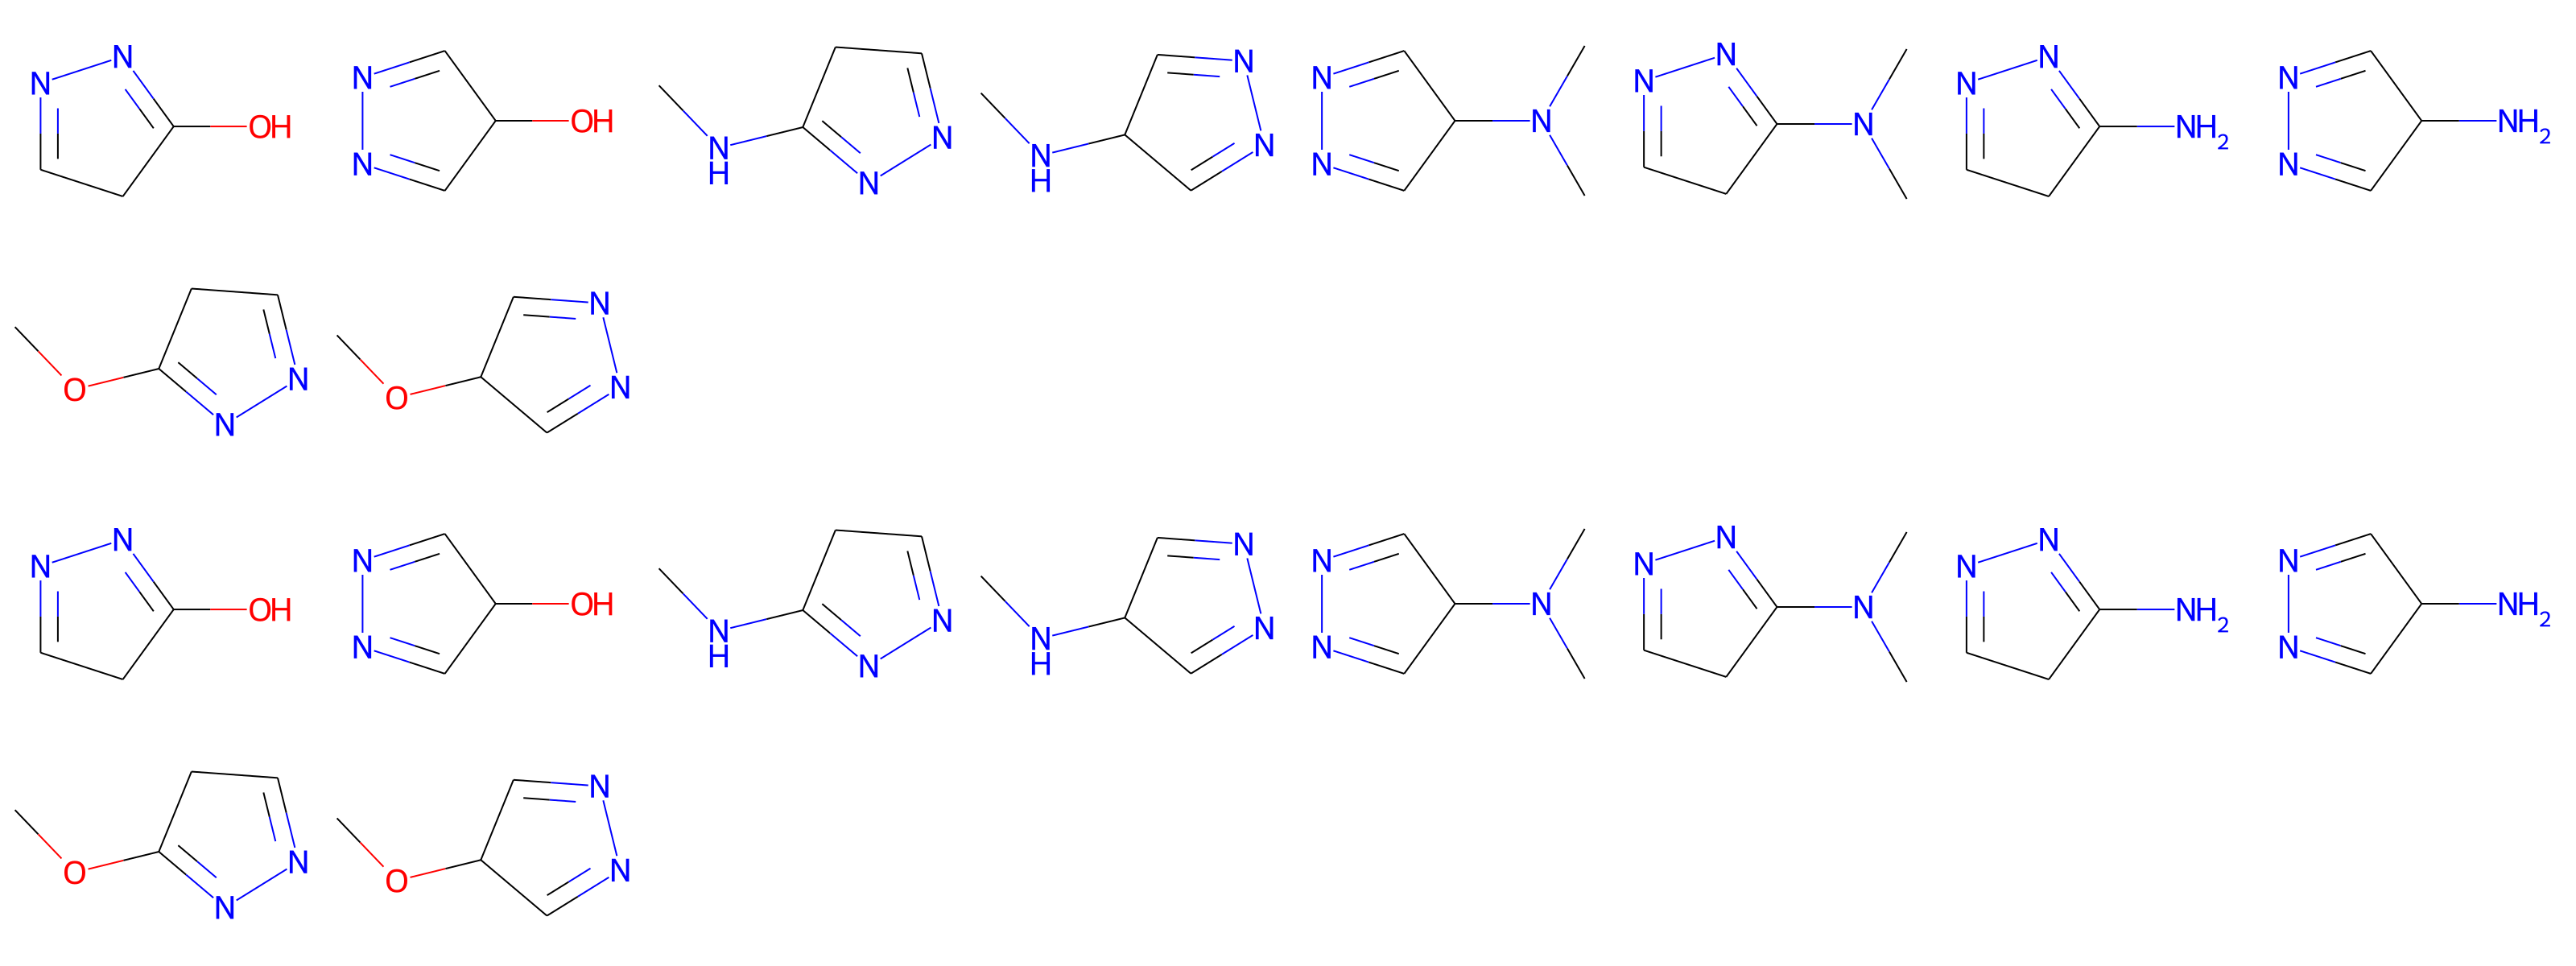

In [84]:
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(p) for p in df1_all['SMILES'] ], molsPerRow=8, maxMols =10, subImgSize=(400, 300), returnPNG=False )
print(img.width)

